<a href="https://colab.research.google.com/github/echoheqian/drug-target-master/blob/main/0608.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
%matplotlib inline
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
py.init_notebook_mode(connected=True)
import warnings
warnings.filterwarnings('ignore')
sys.setrecursionlimit(1000000)

In [ ]:
# set a seed for code reproducibility
SEED = 7
np.random.seed(SEED)
pd.set_option('display.max_columns', 180)

In [ ]:
X_train = pd.read_csv('X_train_selected.csv', sep="\t")
X_val = pd.read_csv('X_val_selected.csv', sep="\t")
X_test = pd.read_csv('X_test_selected.csv', sep="\t")

In [ ]:
# 2.1 Loading data
df = (pd.read_csv('pheno.prs.0607.csv', sep="\t")
        .query('dm_trial==True')
        .drop('dm_trial', axis=1))
df.shape 

(5832, 413)

In [ ]:
# define cvd incidece rate #or x['isch_stroke']==1 or x['hemo_stroke']==1
def get_cvd_type(x):
  if x['mi'] == 1 or x['chd'] ==1 or x['chf'] ==1 or x['mitotal'] or x['psmi'] or x['dsmi']:
    return 1
  else: 
    return 0
df.loc[:, 'cvd_binary'] = df.apply(get_cvd_type, axis=1)
print(df['cvd_binary'].value_counts())

0    5117
1     715
Name: cvd_binary, dtype: int64


In [ ]:
# change missing values of -9 defined previously
df['baseline_sleep'].replace(-9, np.nan, inplace = True)

In [ ]:
# 2.2 detecting missing values
## define count missing values function
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [ ]:
df['DVT'].value_counts()

0.0      5668
amind     162
Name: DVT, dtype: int64

In [ ]:
## count missing values
df_missing = missing_values_table(df)
df_missing

Your selected dataframe has 414 columns.
There are 293 columns that have missing values.


,Missing Values,% of Total Values
WELBEING,5832,100.0
COLON10Y,5832,100.0
HELPCC,5831,100.0
BRCA55,5828,99.9
OVRYCA55,5814,99.7
...,...,...
DVT,2,0.0
time_to_mitotal,2,0.0
RECENCY,1,0.0
DIABTRT,1,0.0


In [ ]:
# detect missing values >40%
df_50_missing = df_missing[df_missing['% of Total Values'] > 40]
df_50_missing.index

Index(['WELBEING', 'COLON10Y', 'HELPCC', 'BRCA55', 'OVRYCA55', 'PEACC1M',
       'MELAN10Y', 'PE6M', 'ENDOCA55', 'ENDO10Y', 'STROKE6M', 'INSULINW',
       'PADANGP', 'PADANGGR', 'PADSURG', 'HORMBK', 'F45STRYR', 'OVRTHYNW',
       'MIAGE', 'MI6M', 'TIA6M', 'DVTACC1M', 'GOITERNW', 'DVT6M', 'NODULENW',
       'F45MVYR', 'FAMILYPENUM', 'ANGNPILN', 'DIABNW', 'DIABPILL', 'INSULIN',
       'DBDIETF2', 'DIABCOMA', 'DIABAGE', 'FAMILYDVTNUM', 'UNDTHYNW', 'NACVD',
       'CHF_F30', 'GALLSTRM', 'GALLBSNW', 'OVRTHY', 'NODULE', 'GALLBLRM',
       'GOITER', 'UNDTHY', 'F45OTHYR', 'F393MSE', 'CARDREST', 'HORM3M',
       'HYPTPILN', 'F45MVMYR', 'HYPTAGE', 'HYPTPILL', 'HYST3M', 'HYSTAGE',
       'AGEHYST', 'insu', 'ldl', 'hdl', 'tg', 'chol', 'hsCRP', 'RHEUMAT',
       'glu', 'F45VITDY', 'COLNSCDT', 'COLOFREL', 'SMOKNOW', 'ad', 'F45CALCY',
       'BRSTFDAL', 'BRSTFDN', 'BRSTFDAF', 'MENPSYAL', 'OSTEOBK', 'HORMNW',
       'time_to_ad', 'MENPSYAF'],
      dtype='object')

In [ ]:
## delete variables with missing values higher than 50%
missing_vars = df_50_missing.index
df_update = (df.drop(missing_vars,axis=1))

In [ ]:
# 更新数据集，删除fid,iid,subjid,visit_year,time_to_event之类的列
drop_cols = ['subjID','FID','IID','time_to_chd','time_to_isch_stroke','time_to_hemo_stroke','time_to_death','time_to_cvd_death','time_to_chf','time_to_dsmi','time_to_dvt','timme_to_psmi',
             'time_to_mitotal',
             'time_to_non_cvd_death','time_to_dm','time_to_mi','time_to_cancer','visit_year','SCORE_delta_sleep_p1_0.05','SCORE_delta_ces_d_p0.05_0.05',
             'SCORE_delta_sleep_p0.05_0.001','SCORE_baseline_sleep_p1_0.05','SCORE_igap_p0.05','SCORE_inso','SCORE_mdd','SCORE_igap',
             'SCORE_baseline_ces_d_p1e5','SCORE_baseline_sleep_p1e5','SCORE_baseline_ces_d_p1','sugar_pct_binary','sugar','SCORE_sugar_baseline_sleep_p0.05',
             'SCORE_sugar_baseline_sleep_p1','SCORE_sugar_baseline_sleep_p1e5','SCORE_sugar_baseline_mse_p1','SCORE_sugar_baseline_mse_p0.05',
             'SCORE_sugar_baseline_mse_p1e5','SCORE_sugar_baseline_ces_d_p1','SCORE_sugar_baseline_ces_d_p0.05','SCORE_sugar_baseline_ces_d_p1e5','race','sex',
             'MENSELST','MEALOUT','DIAB']
df_update1= (df_update.drop(columns=drop_cols))
df_update1.head()

,cancer,fat_down,SCORE_baseline_sleep_p0.05_0.05,sugar_pct,baseline_sugar,SCORE_inso_all_group,baseline_sleep,baseline_tot_cal,baseline_fat,baseline_pro,baseline_cho,baseline_sfa,baseline_mufa,baseline_pufa,baseline_alc,baseline_palm,baseline_n3,hei,myhei,age,BRCA_F2,COLON_F2,ENDO_F2,SKIN_F2,MELAN_F2,OTHCA10Y,HORM,HYST,MALDIET,LFDIETF2,DVT,PE,STROKE,TIA,MI,SCANEMIA,CHF_F2,LIVERDIS,BLDPROB,L15LBS6M,DIALYSIS,OTHCHRON,HARDSTDY,COMECC,HORMSTAT,DIABTRT,dm_intervention,ht_trial,ht_intervention,cad_trial,cad_intervention,EDUC,NOTWRK,RETIRED,HOMEMKR,EMPLOYED,DISABLED,OTHWRK,JOBHMMKR,JOBMANGR,JOBTECH,JOBSERV,JOBLABOR,JOBOTH,MARITAL,PEDUC,INCOME,CAREPROV,ABNPAP3Y,CERVDYS,MAINJOB,HOSP2Y,GLAUCOMA,CATARACT,HICHOLRP,ASTHMA,EMPHYSEM,KIDNEYST,HIBLDCA,STOMULCR,DIVERTIC,COLITIS,LUPUS,PANCREAT,OSTEOPOR,HIPREP,OTHJREP,INTESTRM,MIGRAINE,ALZHEIM,...,HARDEXP,MODEXP,MILDEXP,AVWKEXP,FFWKEXP,VFWKEXP,ALCSWK,ALCOHOL,PACKYRS,PACKYRSC,FAMILYDVTEVR,FAMILYPEEVR,sbp,dbp,bmi,RECENCY,OC,DES,DMPA,TOTE,TOTP,TOTH,TEST,ESTR,F45VITA,F45VITE,F45VITB1,F45VTB12,F45VITB2,F45VITB6,F45BETA,F45BIOT,F45VITC,F45CALC,F45CHROM,F45COPP,F45VITD,F45FOLIC,F45IRON,F45MAGN,F45MANG,F45MOLYB,F45NIAC,F45PANTO,F45RETIN,F45SELEN,F45ZINC,F45MULTI,F45MVMIN,F45STRES,F45OTHCM,F45COMBP,LIFEQUAL,SATLIFE,GENHEL,HLTHC1Y,VIGACT,MODACT,LIFTGROC,HRSSLP,EMOLIMIT,EMOWELL,ENERFAT,HOSTIL,GENHLTH,LFEVENT1,LIVALOR,NEGEMOT,OPTIMISM,PAIN,PSHTDEP,SLPDSTRB,SOCFUNC,SOCSTRN,SOCSUPP,SYMPTOM,chd,isch_stroke,hemo_stroke,death,cvd_death,non_cvd_death,dm,mi,chf,dsmi,dvt,psmi,mitotal,cvd_binary
1,0,True,557.363,0.141641,53.98778,0.000207,7.0,1524.63584,66.72611,60.70822,155.72613,13.92200,24.03499,23.54255,10.01349,8.64331,2.54322,63.98034,-0.003884,51,0.0,0.0,0.0,0.0,0.0,0.0,0.0,amind,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,amind,0.0,0.0,True,True,True,True,True,7.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0,6.0,5.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.000,0.00000,0.0,4.94231,5.0,30.0,3.0,9.0,9.0,125.0,84.0,41.22847,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.0,0.000,0.000,0.000,0,0,0,0,0,9.0,9.0,3.0,4.0,1.0,3.0,3.0,1.0,100.0,84.0,25.0,4.0,70.0,1.0,0.0,3.50,23.0,50.0,0.00144,7.0,100.0,10.0,34.0,0.38235,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,True,545.961,0.209902,64.46801,0.000162,5.0,1228.53449,40.19991,58.67646,160.10975,13.59158,14.54817,8.02075,0.00493,7.44353,0.82732,67.62396,-0.005394,70,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,amind,0.0,0.0,False,True,False,True,False,6.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,7.0,4.0,1.0,0.0,0.0,NaN,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.5,15.75,3.0,0.000,23.33333,0.0,0.00000,2.0,0.0,0.0,0.0,0.0,176.0,92.0,22.30924,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,642.857,12.857,0.643,2.571,0.729,0.857,1928.571,0.0,25.714,69.429,0.0,0.857,4.286,171.429,7.714,42.857,0.0,0.0,8.571,0.0,321.429,8.571,6.429,0,1,0,0,1,10.0,10.0,1.0,2.0,2.0,3.0,3.0,2.0,100.0,80.0,80.0,8.0,90.0,0.0,0.0,2.75,20.0,100.0,0.00552,5.0,100.0,10.0,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,True,559.216,0.141025,86.62391,0.000280,0.0,2456.97239,109.57551,105.39777,268.58096,40.51814,37.89930,22.66372,0.04528,21.16896,2.34198,56.51048,-0.000171,54,0.0,0.0,0.0,0.0,0.0,0.0,0.0,amind,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,amind,0.0,amind,0.0,0.0,False,True,True,True,True,10.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,NaN,3.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.50,0.0,0.000,0.00000,0.0,0.00000,2.0,15.0,2.0,0.0,0.0,104.0,69.0,26.87263,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.0,0.000,0.000,0.000,0,0,0,0,0,8.0,8.0,1.0,3.0,2.0,3.0,3.0,3.0,100.0,88

In [ ]:
# get column names of missing variables
missing_variables = df_update1.isnull().columns
print(missing_variables)

Index(['cancer', 'fat_down', 'SCORE_baseline_sleep_p0.05_0.05', 'sugar_pct',
       'baseline_sugar', 'SCORE_inso_all_group', 'baseline_sleep',
       'baseline_tot_cal', 'baseline_fat', 'baseline_pro',
       ...
       'cvd_death', 'non_cvd_death', 'dm', 'mi', 'chf', 'dsmi', 'dvt', 'psmi',
       'mitotal', 'cvd_binary'],
      dtype='object', length=291)


In [ ]:
# 可视化缺失值
import matplotlib.pyplot as plt
import pylab as pl
# 统计缺失值数量
missing=df_update1.isnull().sum().reset_index().rename(columns={0:'missNum'})
# 计算缺失比例
missing['missRate']=missing['missNum']/df_update1.shape[0]
# 按照缺失率排序显示
miss_analy=missing[missing.missRate>0].sort_values(by='missRate',ascending=False)
# miss_analy 存储的是每个变量缺失情况的数据框

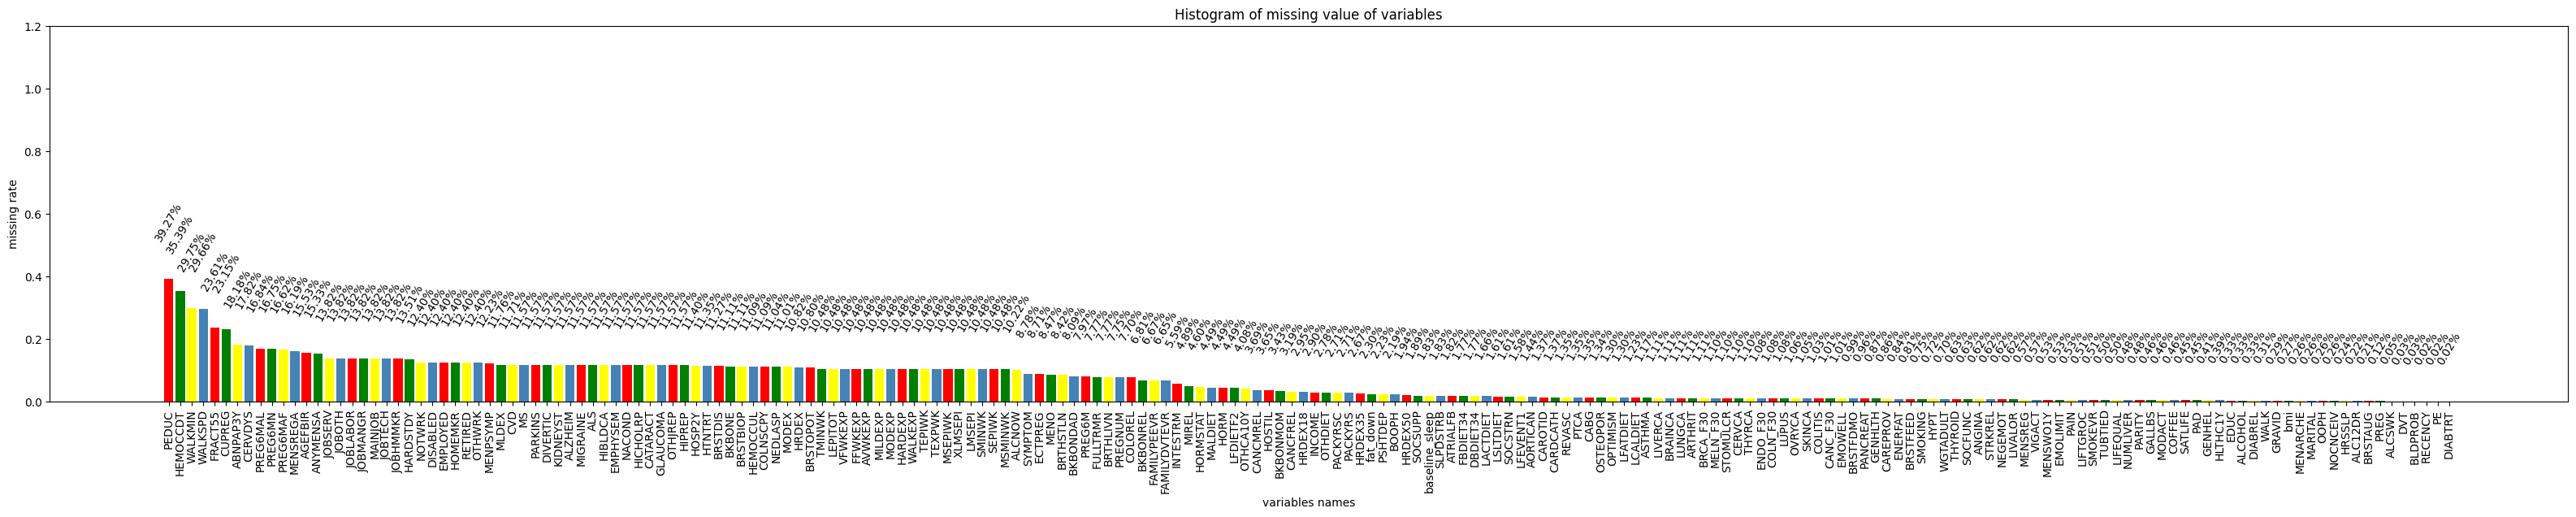

In [ ]:
fig = plt.figure(figsize=(40,6))
plt.bar(np.arange(miss_analy.shape[0]), list(miss_analy.missRate.values), align = 'center',
        color=['red','green','yellow','steelblue'])

plt.title('Histogram of missing value of variables')
plt.xlabel('variables names')
plt.ylabel('missing rate')
# 添加x轴标签，并旋转90度
plt.xticks(np.arange(miss_analy.shape[0]),list(miss_analy['index']))
pl.xticks(rotation=90)
# 添加数值显示
for x,y in enumerate(list(miss_analy.missRate.values)):
    plt.text(x,y+0.12,'{:.2%}'.format(y),ha='center',rotation=60)    
plt.ylim([0,1.2])
    
plt.show()

In [ ]:
# 查看缺失值的数据类型，为后续不同类型填充策略做准备
missing_variables = df_update1.columns[df_update1.isnull().any()]
missing_df = df_update1[missing_variables]

In [ ]:
missing_df.dtypes.value_counts()

float64    190
object      10
dtype: int64

In [ ]:
# 定义热图函数，查看不同缺失值之间的关联
def HeatMap(df, x=True):
  correlations = df.corr()
  ## creat color map ranging between two colors
  ## diverging_palette()为创建两种颜色过渡色板
  cmap = sns.diverging_palette(100, 10,as_cmap=True)
  fig, ax = plt.subplots(figsize=(35,35))
  ## heatmap中参数: vmin和vmax定义图卡颜色，用于锚定颜色图的值
  # cmap 颜色映射名称或对象; fmt 添加注释时要使用的字符串格式化代码
  #fmt='.2f',当Annot为TRUE时才有用，显示数值的小数点位数
  fig = sns.heatmap(correlations, cmap=cmap, vmax=1.0, vmin=-1.0,
                    square=True,linewidths=.05, 
                    annot=False, cbar_kws={'shrink': .25})
                   #mask = abs(correlations) <0.9 )
  fig.set_xticklabels(fig.get_xticklabels(), rotation = 90, fontsize = 9)
  fig.set_yticklabels(fig.get_yticklabels(), rotation = 0, fontsize = 9)
  plt.tight_layout()
  plt.show()
HeatMap(missing_df,x=True)

In [ ]:
#查看缺失值之间的关联性，删除关联系数 >0.9的变量
missing_cor = missing_df.corr()
sub_missing_cor = []
for index in missing_cor.index:
  for i in range(len(missing_cor.loc[index].values)):
     if((missing_cor.loc[index].values[i] >= 0.9) & (missing_cor.loc[index].values[i]<1)):
 #sub = missing_cor.where((np.abs(missing_cor[i]).isin(0.9,1), print(missing_cor.loc[i,i])))
     #sub_missing_cor.append(sub)
        print(index, i)
        print(missing_cor.loc[index].values[i])

In [ ]:
df_update1 = (df_update1.drop(columns=['MSMINWK','HTNTRT','BRTHLIVN','PARITY','BRSTDIS','SMOKING','NUMLIVER','SEPIWK','TMINWK','TEXPWK','HARDEXP']))

In [ ]:
# 查看缺失值的数据类型，为后续不同类型填充策略做准备
missing_variables = df_update1.columns[df_update1.isnull().any()]
missing_df =  df_update1[missing_variables]
#HeatMap(missing_df,x=True)

In [ ]:
missing_values_table(df_update1)

Your selected dataframe has 280 columns.
There are 189 columns that have missing values.


,Missing Values,% of Total Values
PEDUC,2290,39.3
HEMOCCDT,2064,35.4
WALKMIN,1735,29.7
WALKSPD,1730,29.7
FRACT55,1377,23.6
...,...,...
BLDPROB,2,0.0
DVT,2,0.0
DIABTRT,1,0.0
PE,1,0.0


In [ ]:
df_update2['MI'].value_counts()

0.0    5698
1       134
Name: MI, dtype: int64

In [ ]:
### 将缺失列中的文本数据填充为NAN为连续变量插入缺失值
df_update2 = df_update1.replace('amind', 1)
df_update3 = df_update2.replace('asian',np.nan)
df_update3[missing_variables].dtypes.value_counts()

float64    179
object      17
dtype: int64

In [ ]:
## count missing values
df3_missing = missing_values_table(df_update3)
df3_missing

Your selected dataframe has 280 columns.
There are 189 columns that have missing values.


,Missing Values,% of Total Values
PEDUC,2290,39.3
HEMOCCDT,2064,35.4
HORMSTAT,2034,34.9
WALKMIN,1735,29.7
WALKSPD,1730,29.7
...,...,...
BLDPROB,2,0.0
DVT,2,0.0
DIABTRT,1,0.0
PE,1,0.0


In [ ]:
# detect missing values >40%
df3_40_missing = df3_missing[df3_missing['% of Total Values'] > 40]
df3_40_missing.index

Index([], dtype='object')

In [ ]:
## delete variables with missing values higher than 50%
missing_vars = df3_40_missing.index
df_update4 = (df_update3.drop(missing_vars,axis=1))

In [ ]:
#df_update4 = (df_update4.drop(columns=['ENDO_F2','SKIN_F2','MELAN_F2','OTHCA10Y','MALDIET','LFDIETF2','DVT','PE','STROKE','TIA','MI','CHF_F2','LIVERDIS','BLDPROB','OTHCHRON','HARDSTDY']))

In [ ]:
missing_values_table(df_update4)

Your selected dataframe has 280 columns.
There are 189 columns that have missing values.


,Missing Values,% of Total Values
PEDUC,2290,39.3
HEMOCCDT,2064,35.4
HORMSTAT,2034,34.9
WALKMIN,1735,29.7
WALKSPD,1730,29.7
...,...,...
BLDPROB,2,0.0
DVT,2,0.0
DIABTRT,1,0.0
PE,1,0.0


In [ ]:
df_update4.to_csv('pheno.prs.0607.csv', sep=",", index = False)

In [ ]:
df_update4 = pd.read_csv('pheno.prs.0531.csv', sep=",")

## 缺失值填充

In [ ]:
## 将连续变量和分类变量分开填充
## example 
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.base import TransformerMixin

In [ ]:
# 定义热图函数，查看不同缺失值之间的关联
def HeatMap(df, x=True):
  correlations = df.corr()
  ## creat color map ranging between two colors
  ## diverging_palette()为创建两种颜色过渡色板
  cmap = sns.diverging_palette(100, 10,as_cmap=True)
  fig, ax = plt.subplots(figsize=(35,35))
  ## heatmap中参数: vmin和vmax定义图卡颜色，用于锚定颜色图的值
  # cmap 颜色映射名称或对象; fmt 添加注释时要使用的字符串格式化代码
  #fmt='.2f',当Annot为TRUE时才有用，显示数值的小数点位数
  fig = sns.heatmap(correlations, cmap=cmap, vmax=1.0, vmin=-1.0,
                    square=True,linewidths=.05, 
                    annot=False, cbar_kws={'shrink': .25})
                   #mask = abs(correlations) <0.9 )
  fig.set_xticklabels(fig.get_xticklabels(), rotation = 90, fontsize = 9)
  fig.set_yticklabels(fig.get_yticklabels(), rotation = 0, fontsize = 9)
  plt.tight_layout()
  plt.show()
#HeatMap(missing_df,x=True)

In [ ]:
missing_variables = df_update4.columns[df_update4.isnull().any()]
missing_df =  df_update4[missing_variables]

#### 缺失值填充（方法一）通过变量类型填充缺失值

In [ ]:
 missing = missing_values_table(df_update4)
 missing

Your selected dataframe has 280 columns.
There are 189 columns that have missing values.


,Missing Values,% of Total Values
PEDUC,2290,39.3
HEMOCCDT,2064,35.4
HORMSTAT,2034,34.9
WALKMIN,1735,29.7
WALKSPD,1730,29.7
...,...,...
BLDPROB,2,0.0
DVT,2,0.0
DIABTRT,1,0.0
PE,1,0.0


In [ ]:
df_update4.isna().sum()

cancer                               0
fat_down                           134
SCORE_baseline_sleep_p0.05_0.05      0
sugar_pct                            0
baseline_sugar                       0
                                  ... 
dsmi                                 0
dvt                                  0
psmi                                 0
mitotal                              0
cvd_binary                           0
Length: 280, dtype: int64

In [ ]:
df_update4.head()

,cancer,fat_down,SCORE_baseline_sleep_p0.05_0.05,sugar_pct,baseline_sugar,SCORE_inso_all_group,baseline_sleep,baseline_tot_cal,baseline_fat,baseline_pro,baseline_cho,baseline_sfa,baseline_mufa,baseline_pufa,baseline_alc,baseline_palm,baseline_n3,hei,myhei,age,BRCA_F2,COLON_F2,ENDO_F2,SKIN_F2,MELAN_F2,OTHCA10Y,HORM,HYST,MALDIET,LFDIETF2,DVT,PE,STROKE,TIA,MI,SCANEMIA,CHF_F2,LIVERDIS,BLDPROB,L15LBS6M,DIALYSIS,OTHCHRON,HARDSTDY,COMECC,HORMSTAT,DIABTRT,dm_intervention,ht_trial,ht_intervention,cad_trial,cad_intervention,EDUC,NOTWRK,RETIRED,HOMEMKR,EMPLOYED,DISABLED,OTHWRK,JOBHMMKR,JOBMANGR,JOBTECH,JOBSERV,JOBLABOR,JOBOTH,MARITAL,PEDUC,INCOME,CAREPROV,ABNPAP3Y,CERVDYS,MAINJOB,HOSP2Y,GLAUCOMA,CATARACT,HICHOLRP,ASTHMA,EMPHYSEM,KIDNEYST,HIBLDCA,STOMULCR,DIVERTIC,COLITIS,LUPUS,PANCREAT,OSTEOPOR,HIPREP,OTHJREP,INTESTRM,MIGRAINE,ALZHEIM,...,WALKEXP,MODEXP,MILDEXP,AVWKEXP,FFWKEXP,VFWKEXP,ALCSWK,ALCOHOL,PACKYRS,PACKYRSC,FAMILYDVTEVR,FAMILYPEEVR,sbp,dbp,bmi,RECENCY,OC,DES,DMPA,TOTE,TOTP,TOTH,TEST,ESTR,F45VITA,F45VITE,F45VITB1,F45VTB12,F45VITB2,F45VITB6,F45BETA,F45BIOT,F45VITC,F45CALC,F45CHROM,F45COPP,F45VITD,F45FOLIC,F45IRON,F45MAGN,F45MANG,F45MOLYB,F45NIAC,F45PANTO,F45RETIN,F45SELEN,F45ZINC,F45MULTI,F45MVMIN,F45STRES,F45OTHCM,F45COMBP,LIFEQUAL,SATLIFE,GENHEL,HLTHC1Y,VIGACT,MODACT,LIFTGROC,HRSSLP,EMOLIMIT,EMOWELL,ENERFAT,HOSTIL,GENHLTH,LFEVENT1,LIVALOR,NEGEMOT,OPTIMISM,PAIN,PSHTDEP,SLPDSTRB,SOCFUNC,SOCSTRN,SOCSUPP,SYMPTOM,chd,isch_stroke,hemo_stroke,death,cvd_death,non_cvd_death,dm,mi,chf,dsmi,dvt,psmi,mitotal,cvd_binary
1,0,True,557.363,0.141641,53.98778,0.000207,7.0,1524.63584,66.72611,60.70822,155.72613,13.92200,24.03499,23.54255,10.01349,8.64331,2.54322,63.98034,-0.003884,51,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,True,True,True,True,True,7.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0,6.0,5.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.00,0.0,0.000,0.00000,0.0,4.94231,5.0,30.0,3.0,9.0,9.0,125.0,84.0,41.22847,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.0,0.000,0.000,0.000,0,0,0,0,0,9.0,9.0,3.0,4.0,1.0,3.0,3.0,1.0,100.0,84.0,25.0,4.0,70.0,1.0,0.0,3.50,23.0,50.0,0.00144,7.0,100.0,10.0,34.0,0.38235,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,True,545.961,0.209902,64.46801,0.000162,5.0,1228.53449,40.19991,58.67646,160.10975,13.59158,14.54817,8.02075,0.00493,7.44353,0.82732,67.62396,-0.005394,70,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,False,True,False,True,False,6.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,7.0,4.0,1.0,0.0,0.0,NaN,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,23.33333,15.75,3.0,0.000,23.33333,0.0,0.00000,2.0,0.0,0.0,0.0,0.0,176.0,92.0,22.30924,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,642.857,12.857,0.643,2.571,0.729,0.857,1928.571,0.0,25.714,69.429,0.0,0.857,4.286,171.429,7.714,42.857,0.0,0.0,8.571,0.0,321.429,8.571,6.429,0,1,0,0,1,10.0,10.0,1.0,2.0,2.0,3.0,3.0,2.0,100.0,80.0,80.0,8.0,90.0,0.0,0.0,2.75,20.0,100.0,0.00552,5.0,100.0,10.0,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,True,559.216,0.141025,86.62391,0.000280,0.0,2456.97239,109.57551,105.39777,268.58096,40.51814,37.89930,22.66372,0.04528,21.16896,2.34198,56.51048,-0.000171,54,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,1,0.0,0.0,False,True,True,True,True,10.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,NaN,3.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,1.50,0.0,0.000,0.00000,0.0,0.00000,2.0,15.0,2.0,0.0,0.0,104.0,69.0,26.87263,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.0,0.000,0.000,0.000,0,0,0,0,0,8.0,8.0,1.0,3.0,2.0,3.0,3.0,3.0,100.0,88.0,65.0,1.0

In [ ]:
### 区分数据中的数值变量和离散变量，对不同的变量类型分别采用不同的填充策略
## O_index:   数值变量列名
##C :离散变量列名
def distinguish_Char_Num(DataFrame_data):
  import copy
  m, n = DataFrame_data.shape
  O = []
  C = []
  data = copy.deepcopy(DataFrame_data)
  for i in range(n):
    try:
      if isinstance(data.iloc[0, i], int) or isinstance(data.iloc[0, i], float) or isinstance(data.iloc[0, i],  np.float64)  or isinstance(data.iloc[0, i], np.int64) or isinstance(data.iloc[0, i], np.int32):
          O.append(i)
      elif isinstance(data.iloc[0, i], object):
          C.append(i)
      else:
            raise ValueError("the %d colum of data is ot a umber or object")
    except TypeError as e:
          print(e)
  O_data = copy.deepcopy(data.iloc[:, O])
  C_data = copy.deepcopy(data.iloc[:, C])
  O_index = O_data.columns.tolist()
  C_index = C_data.columns.tolist()
  return O_index, C_index
# 取得两类变量类型的名称
O_index, C_index = distinguish_Char_Num(df_update4[missing_variables])
# 连续变量 
O_index
# 离散变量
C_index

['OTHCA10Y',
 'HORM',
 'MALDIET',
 'LFDIETF2',
 'DVT',
 'PE',
 'BLDPROB',
 'HORMSTAT',
 'DIABTRT']

In [ ]:
df_update4.iloc[:,1].unique()

array([True, nan, False], dtype=object)

In [ ]:
## 2023-06-01
y_train = X_train['mi']
y_val = X_val['mi']
y_test = X_test['mi']


In [ ]:
#
X_train.drop(columns=['mi'], inplace = True)
X_val.drop(columns=['mi'], inplace = True)
X_test.drop(columns=['mi'], inplace = True)
#
selected_features_train = X_train.columns
selected_features_val = X_val.columns
selected_features_test = X_test.columns

In [ ]:
X_test

In [ ]:
lr = RandomForestClassifier(n_estimators=100, random_state=42)

In [ ]:
lr.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Test AUC: 0.6403507081927711


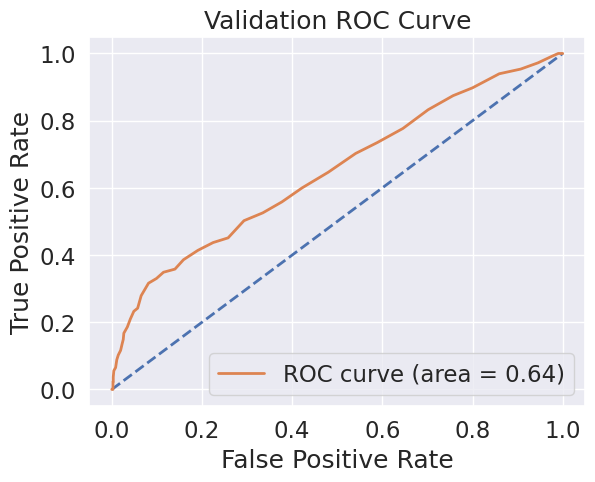

In [ ]:
#lr = LogisticRegression(solver='newton-cg', class_weight='balanced')
lr = RandomForestClassifier(n_estimators=100, random_state=42)
lr.fit(X_train, y_train)
cv = KFold(n_splits=5, shuffle=True, random_state=42)
#val_auc = cross_val_score(lr, X_val, y_val, scoring='roc_auc', cv=cv).mean()
test_auc = cross_val_score(lr, X_test, y_test, scoring='roc_auc', cv=cv).mean()

#print('Validation AUC:', val_auc)
print('Test AUC:', test_auc)

test_prob = lr.predict_proba(X_test)[:, 1]
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, test_prob)
#auc = metrics.auc(fpr_test, tpr_test)
# plot ROC vurve
plt.figure()
lw = 2
plt.plot([0,1],[0,1], lw = lw, linestyle = '--')
plt.plot(fpr_test, tpr_test, lw = lw, label='ROC curve (area = %0.2f)' % test_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation ROC Curve')
plt.legend(loc ="lower right")
plt.show()

In [ ]:
print(auc)

0.6472918718278917


###### 缺失值填充（方法二）通过变量数值的数量填充

In [ ]:
### 方法二： 区分数据中的数值变量和离散变量，对不同的变量类型分别采用不同的填充策略
def check_var(DataFrame_data):
  import copy
  m, n = DataFrame_data.shape
  O1 = []
  C1 = []
  data = copy.deepcopy(DataFrame_data)
  for i in range(n):
      if len(data.iloc[:,i].unique()) > 13:
          O1.append(i)
      else:
          C1.append(i)
  O1_data = copy.deepcopy(data.iloc[:, O1])
  C1_data = copy.deepcopy(data.iloc[:, C1])
  O1_index = O1_data.columns.tolist()
  C1_index = C1_data.columns.tolist()
  return O1_index, C1_index
# 取得两类变量类型的名称
O1_index, C1_index = check_var(df_update4[missing_variables])
# 连续变量 
print(O1_index)
# 离散变量
print(C1_index)

['baseline_sleep', 'ANYMENSA', 'MENO', 'TEPIWK', 'LEPITOT', 'MSEPIWK', 'XLMSEPI', 'SMINWK', 'WALKEXP', 'MODEXP', 'MILDEXP', 'AVWKEXP', 'FFWKEXP', 'ALCSWK', 'PACKYRS', 'bmi', 'EMOWELL', 'ENERFAT', 'HOSTIL', 'GENHLTH', 'NEGEMOT', 'OPTIMISM', 'PSHTDEP', 'SLPDSTRB', 'SOCSTRN', 'SOCSUPP', 'SYMPTOM']
['fat_down', 'OTHCA10Y', 'HORM', 'MALDIET', 'LFDIETF2', 'DVT', 'PE', 'BLDPROB', 'HARDSTDY', 'HORMSTAT', 'DIABTRT', 'EDUC', 'NOTWRK', 'RETIRED', 'HOMEMKR', 'EMPLOYED', 'DISABLED', 'OTHWRK', 'JOBHMMKR', 'JOBMANGR', 'JOBTECH', 'JOBSERV', 'JOBLABOR', 'JOBOTH', 'MARITAL', 'PEDUC', 'INCOME', 'CAREPROV', 'ABNPAP3Y', 'CERVDYS', 'MAINJOB', 'HOSP2Y', 'GLAUCOMA', 'CATARACT', 'HICHOLRP', 'ASTHMA', 'EMPHYSEM', 'KIDNEYST', 'HIBLDCA', 'STOMULCR', 'DIVERTIC', 'COLITIS', 'LUPUS', 'PANCREAT', 'OSTEOPOR', 'HIPREP', 'OTHJREP', 'INTESTRM', 'MIGRAINE', 'ALZHEIM', 'MS', 'PARKINS', 'ALS', 'NACOND', 'CVD', 'CARDCATH', 'CABG', 'PTCA', 'CAROTID', 'ATRIALFB', 'AORTICAN', 'ARTHRIT', 'GALLBS', 'THYROID', 'HYPT', 'ANGINA', 'P

In [ ]:
df_update4[missing_variables].dtypes.value_counts()

float64    179
object      10
dtype: int64

In [ ]:
# 填补缺失值数据类型为OBJECT类型的分类变量数据，填补的方法为填充为类别多的值
#class DataFrameImputer(TransformerMixin):
#  def _init_(self):
#    """Impute missing values.
#     Columns of dype object are imputed with MICE category variables in columns.
#     Columns of float types are imputed with MICE continueous variables in columns.
#    """
#  def fit(self, X, y=None):
#      self.fill = pd.Series([X[c].value_counts().index[0] 
#                      if X[c].dtypes == 'object' else np.nan for c in X],
#                      index = X.columns)
#      
#      return self

#  def transform(self, X, Y=None):
#        return X.fillna(self.fill)
#xt_obj_complete = DataFrameImputer().fit_transform(df_update4)
#xt_obj_complete.dtypes.value_counts()


In [ ]:
#missing_values_table(xt_obj_complete)

####2）填补为类别分类变量的缺失值，采用中位数填补

In [ ]:
df_update4['fat_down']= df_update4['fat_down'].fillna(0)

In [ ]:
df_update4['fat_down']= df_update4['fat_down'].astype(int)

In [ ]:
i = ['dm_intervention','ht_trial','ht_intervention','cad_trial','cad_intervention']
for col in i:
 df_update4[col]= df_update4[col].astype(int)

In [ ]:
 df_update4.iloc[:,1].unique()

array([1, 0])

In [ ]:
df_update4.dtypes.value_counts()

float64    230
int64       27
object      23
dtype: int64

In [ ]:
#df_update4['SOCFUNC'] = df_update4['SOCFUNC'].fillna((df_update4.loc[df_update4['SOCFUNC'].isnull() == False, 'SOCFUNC']).mode())

In [ ]:
for col_name in C1_index:
    print(df_update4.loc[df_update4[col_name].isnull() == False, col_name].mode())

In [ ]:
df_update4.head()

In [ ]:
## 填补经UNIQUE判断出的分类变量数据，填补类型为中位数
# C1_index 为分类数据
print(C1_index)
for col_name in C1_index:
    #print(col_name)
     df_update4[col_name] = df_update4[col_name].fillna(df_update4.loc[df_update4[col_name].isnull() == False, col_name].median())

['fat_down', 'OTHCA10Y', 'HORM', 'MALDIET', 'LFDIETF2', 'DVT', 'PE', 'BLDPROB', 'HARDSTDY', 'HORMSTAT', 'DIABTRT', 'EDUC', 'NOTWRK', 'RETIRED', 'HOMEMKR', 'EMPLOYED', 'DISABLED', 'OTHWRK', 'JOBHMMKR', 'JOBMANGR', 'JOBTECH', 'JOBSERV', 'JOBLABOR', 'JOBOTH', 'MARITAL', 'PEDUC', 'INCOME', 'CAREPROV', 'ABNPAP3Y', 'CERVDYS', 'MAINJOB', 'HOSP2Y', 'GLAUCOMA', 'CATARACT', 'HICHOLRP', 'ASTHMA', 'EMPHYSEM', 'KIDNEYST', 'HIBLDCA', 'STOMULCR', 'DIVERTIC', 'COLITIS', 'LUPUS', 'PANCREAT', 'OSTEOPOR', 'HIPREP', 'OTHJREP', 'INTESTRM', 'MIGRAINE', 'ALZHEIM', 'MS', 'PARKINS', 'ALS', 'NACOND', 'CVD', 'CARDCATH', 'CABG', 'PTCA', 'CAROTID', 'ATRIALFB', 'AORTICAN', 'ARTHRIT', 'GALLBS', 'THYROID', 'HYPT', 'ANGINA', 'PAD', 'COLNSCPY', 'HEMOCCUL', 'HEMOCCDT', 'CANC_F30', 'BRCA_F30', 'OVRYCA', 'ENDO_F30', 'COLN_F30', 'THYRCA', 'CERVCA', 'SKINCA', 'MELN_F30', 'LIVERCA', 'LUNGCA', 'BRAINCA', 'BKBONE', 'FRACT55', 'REVASC', 'MENARCHE', 'MENSREG', 'MENSREGA', 'MENSWO1Y', 'MENPSYMP', 'PREG', 'PREGNUM', 'PREG6M', 'PRE

####3）填补变量缺失率小与0.2的缺失值，采用均值填充

In [ ]:
 # 再核对一遍填充数据的效果
 missing = missing_values_table(df_update4)
 missing

In [ ]:
### 采用均值填充缺失值比例<2%的连续变量
# 筛选出缺失值比例< 2%的变量，直接用均值填充
O1_index_low = missing[(missing['% of Total Values'] < 2) ].index
print(O1_index_low)
for col_name in O1_index_low:
      df_update4[col_name] = df_update4[col_name].fillna(df_update4.loc[df_update4[col_name].isnull() == False, col_name].mean())

Index([], dtype='object')


In [ ]:
# 核对一遍填充缺失值< 0.2数据的效果
missing_values_table(df_update4)

Your selected dataframe has 280 columns.
There are 16 columns that have missing values.


,Missing Values,% of Total Values
ANYMENSA,894,15.3
TEPIWK,611,10.5
LEPITOT,611,10.5
MSEPIWK,611,10.5
XLMSEPI,611,10.5
SMINWK,611,10.5
WALKEXP,611,10.5
MODEXP,611,10.5
MILDEXP,611,10.5
AVWKEXP,611,10.5


In [ ]:
df_update4.head()

In [ ]:
# 删除其他cvd的患病情况
cvd_vars = ['chd','isch_stroke','hemo_stroke','death','cvd_death','non_cvd_death','cancer','chf','dm','mi','dsmi','psmi','mitotal','dvt']
df_update5= (df_update4.drop(cvd_vars, axis=1))
df_name = df_update5.columns
df_name

Index(['fat_down', 'SCORE_baseline_sleep_p0.05_0.05', 'sugar_pct',
       'baseline_sugar', 'SCORE_inso_all_group', 'baseline_sleep',
       'baseline_tot_cal', 'baseline_fat', 'baseline_pro', 'baseline_cho',
       ...
       'NEGEMOT', 'OPTIMISM', 'PAIN', 'PSHTDEP', 'SLPDSTRB', 'SOCFUNC',
       'SOCSTRN', 'SOCSUPP', 'SYMPTOM', 'cvd_binary'],
      dtype='object', length=266)

####4）采用MICE方法填充连续变量

In [ ]:
### 采用MICE方法填充连续变量
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from numpy import mean
from numpy import std
from pandas import read_csv
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline

In [ ]:
# 方法一：采用固定参数 进行多重插补填充缺失值
mice_imputer = IterativeImputer(imputation_order='ascending',max_iter=500,random_state=42,n_nearest_features=5)

#['insu','ldl','hdl','chol','tg','glu','sbp','dbp',
variables =  missing_values_table(df_update5).index
for i in variables:
  df_update5[i] = mice_imputer.fit_transform(df_update5[[i]])

Your selected dataframe has 266 columns.
There are 16 columns that have missing values.


In [ ]:
# 方法二：创建建模通道，历遍不同参数，看哪个参数的效果最好
from matplotlib import pyplot
#LR_results = list()
LR_AUC_results = list()
#strategies = ['ascending','descending','roman','arabic','random']wertyuiop
strategies = [str(i) for i in range(1,5)]
#strategy = [str[i] for i i rage(1,50)]
for s in strategies: 
#  for s in strategy:
     model = LogisticRegression(solver='newton-cg', class_weight='balanced')
     imputer = IterativeImputer(max_iter=int(s))
     scaler = StandardScaler()
     pipeline1 = Pipeline(steps = [('i',imputer), ('m', model)])
     cv = RepeatedStratifiedKFold(n_splits=5,n_repeats=2, random_state=1)
# 评估模型
     scores_auc =  cross_val_score(pipeline1, X_train, y_train,
												 scoring='roc_auc',
												 cv=cv , 
                         n_jobs=-1,
                         error_score = 'raise')
    #LR_results.append(scores)
     LR_AUC_results.append(scores_auc)
     print('>%s %.3f (%.3f)' % (s, mean(scores_auc), std(scores_auc)))

In [ ]:
def HeatMap(df, x=True):
  correlations = df.corr()
  ## creat color map ranging between two colors
  ## diverging_palette()为创建两种颜色过渡色板
  cmap = sns.diverging_palette(220, 10,as_cmap=True)
  fig, ax = plt.subplots(figsize=(20,20))
  ## heatmap中参数: vmin和vmax定义图卡颜色，用于锚定颜色图的值
  # cmap 颜色映射名称或对象; fmt 添加注释时要使用的字符串格式化代码
  # fmt='.2f',
  fig = sns.heatmap(correlations, cmap=cmap, vmax=1.0, vmin=-1.0,
                    square=True,linewidths=.5, 
                    annot=False, cbar_kws={'shrink': .75})
  fig.set_xticklabels(fig.get_xticklabels(), rotation = 60, fontsize = 10)
  fig.set_yticklabels(fig.get_yticklabels(), rotation = 0, fontsize = 10)
  plt.tight_layout()
  plt.show()

In [ ]:
# Load libraries
from pandas import set_option
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import learning_curve

In [ ]:
print(df_update5['cvd_binary'].value_counts())
df_name = df_update5.columns

0    5117
1     715
Name: cvd_binary, dtype: int64


In [ ]:
df_update5.shape

(5832, 266)

In [ ]:
X = df_update5.drop(['cvd_binary'], axis=1)
Y = df_update5['cvd_binary']

In [ ]:
## 划分数据集
#X = df_update4[feature_index]
#Y = df_update4[df_name[0]]
X_train, X_test, y_train, y_test = train_test_split(
    X,Y,
    test_size=0.3,
    random_state=0,
    stratify=Y
)

In [ ]:
print("There are {} training samples".format(y_train.shape[0]))
print("There are {} testing samples".format(X_test.shape[0]))

There are 4082 training samples
There are 1750 testing samples


### 绘制学习曲线，诊断模型

In [ ]:
Y.head()

1     0
2     0
5     0
10    0
17    0
Name: cvd_binary, dtype: int64

In [ ]:
from sklearn.model_selection import ShuffleSplit
# , scoring ="accuracy"
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes = np.linspace(.1, 1.0, 5), scoring ="roc_auc"):
       '''绘制学习曲线
       ''' 
       plt.title(title)
       if ylim is not None:
             plt.ylim(*ylim)
       plt.xlabel('Training examples')
       plt.ylabel('Score')
       train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
       train_scores_mean = np.mean(train_scores, axis=1)
       train_scores_std = np.std(train_scores, axis=1)
       test_scores_mean = np.mean(test_scores, axis=1)
       test_scores_std = np.std(test_scores, axis=1)

       plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha =0.1,
                      color='r')
       plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha =0.1,
                      color='g' )
       plt.plot(train_sizes, train_scores_mean, "o-", color='r', label='Training score')
       plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
       plt.legend(loc='best')
       return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

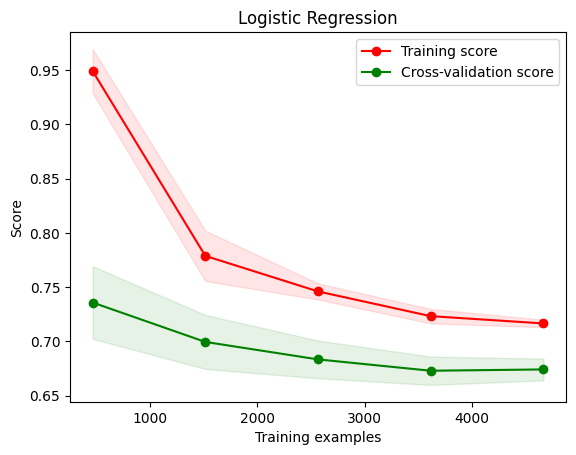

In [ ]:
X, y = X, Y
cv = ShuffleSplit(n_splits=5, test_size = 0.2, random_state=42)
titles = 'Logistic Regression'
# solver 决定了我们对逻辑回归损失函数的优化方法：# lbfgs,' newton_cg', 'liblinear', 'sag', 'saga'
estimator =  LogisticRegression(solver='liblinear', class_weight='balanced') 
plot_learning_curve(estimator, titles, X, Y, cv = cv, n_jobs = -1)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

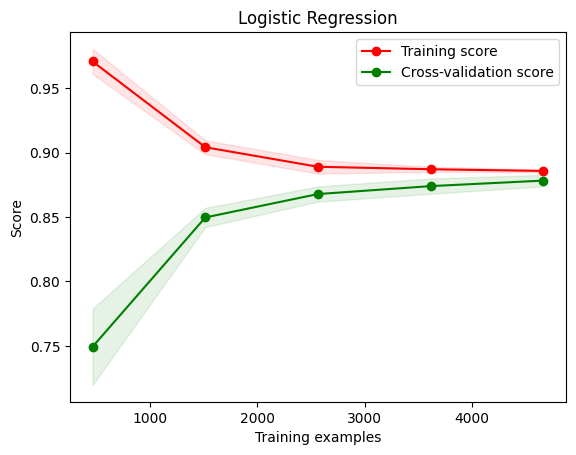

In [ ]:
X, y = X, Y
cv = ShuffleSplit(n_splits=5, test_size = 0.2, random_state=42)
titles = 'Logistic Regression'
# solver 决定了我们对逻辑回归损失函数的优化方法：# lbfgs,' newton_cg', 'liblinear', 'sag', 'saga'
estimator =  LinearDiscriminantAnalysis() 
plot_learning_curve(estimator, titles, X, Y, cv = cv, n_jobs = -1)

In [ ]:
# load libraries
import pandas as pd
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation


In [ ]:
## ExtraTreesClassifier 它将森林中收集的多个去相关决策树的结果聚集起来输出分类结果
clf = ExtraTreesClassifier(n_estimators=250,
                              random_state=SEED)

clf.fit(X_train, y_train)

# #############################################################################
# Plot feature importance
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[::-1]
sorted_idx_30 = sorted_idx[0:30]
pos = np.arange(sorted_idx.shape[0]) + .5
pos_30 = pos[0:30]


In [ ]:
df_update5.columns[sorted_idx]

Index(['HYPT', 'DIABTRT', 'sbp', 'age', 'INCOME', 'GENHLTH', 'LIFTGROC',
       'HOSTIL', 'WALKSPD', 'OPTIMISM',
       ...
       'BRCA_F2', 'COLON_F2', 'COMECC', 'OTHCA10Y', 'HARDSTDY', 'MALDIET',
       'LFDIETF2', 'DIALYSIS', 'L15LBS6M', 'SCANEMIA'],
      dtype='object', length=265)

In [ ]:
# 构建排序后的特征
sortindex = np.argsort(clf.feature_importances_)[::-1]
feature_index = []
for i in sortindex:
  if clf.feature_importances_[i] > 0.005:
      feature_index.append(df_update5.columns[i])
      print('%s\t%.5f'%(df_update5.columns[i], clf.feature_importances_[i]))

In [ ]:
feature_index

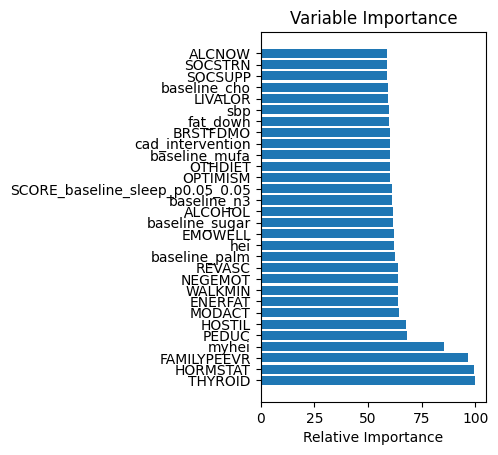

In [ ]:
plt.subplot(1, 2, 2)
plt.barh(pos_30, feature_importance[sorted_idx_30], align='center')
plt.yticks(pos_30, df_update4.columns[sorted_idx_30], fontsize =10)#boston.feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [ ]:
# Building Decision Tree Model
# create Decision Tree classifer object
Tree = DecisionTreeClassifier(random_state=0)

# train decision tree classifer
Tree.fit(X_train, y_train)
features = X_train.columns
# 交叉验证评估
score1 = cross_val_score(Tree, X_train, y_train, cv = 5).mean()
score2 = Tree.score(X_test, y_test)
print(score1)
print(score2)
# 查看数据集分布是否平衡，如不平衡，可以采用sample_weight设置
y_train.value_counts()

0.7858857129142967
0.7828571428571428


0    3582
1     500
Name: cvd_binary, dtype: int64

In [ ]:
# 选择2: 采用网格搜索调整参数
param = {'max_depth':[*range(1,10)],
         'splitter':('best','random'),
         'criterion':('gini','entropy'),
         'min_impurity_decrease':[*np.linspace(0,0.5,20)],
         'min_samples_leaf':[*range(1,50,5)] # 2
         }
Tree = DecisionTreeClassifier(random_state=0)
GS = GridSearchCV(Tree, param, cv=5)
GS.fit(X_train, y_train)
print(GS.best_params_)
print(GS.best_score_)

### 2023-05-31搜索GBM算法最优参数，并组合

In [ ]:
# 调GBM的参数
gbm0 = GradientBoostingClassifier(random_state=10)

num_folds = 10
  # score 的类型可以选择"accuracy"，"roc_auc", "f1", "precesion", "recall"
scoring = "roc_auc"
results = []
names = []
  # StratifiedKFold 保证训练集中每一类的比例是相同的,其中参数含义：n_splits为折叠次数,shuffle: 是否在每次分割之前打乱顺序
  # cross_val_score 为交叉验证函数，其中参数含义，cv为每次选择验证折数 
kfold = StratifiedKFold(n_splits=num_folds, random_state=SEED,shuffle=True)
cv_results = cross_val_score(gbm0, X_train, y_train, cv=kfold, scoring=scoring)
print(cv_results)

[0.71532033 0.68685237 0.71798883 0.67776536 0.67960894 0.66050279
 0.69122905 0.65519553 0.62854749 0.63569832]


In [ ]:
param_test1 = {'n_estimators':  range(20, 81, 10)}
gsearch1 = GridSearchCV(estimator=GradientBoostingClassifier(learning_rate=0.1, min_samples_split=300,
                                                             min_samples_leaf=20, max_depth=8, max_features="sqrt", subsample=0.8,random_state=10),
                        param_grid = param_test1, scoring = 'roc_auc', cv=5)
gsearch1.fit(X_train, y_train)
gsearch1.best_params_, gsearch1.best_score_

({'n_estimators': 20}, 0.6829999688335164)

In [ ]:
param_test2 = {'max_depth':range(3,14,2), 'min_samples_split':range(100, 801, 200)}
gsearch2 = GridSearchCV(estimator=GradientBoostingClassifier(learning_rate=0.1,n_estimators=20,
                                                             min_samples_leaf=20,  max_features="sqrt", subsample=0.8,random_state=10),
                        param_grid = param_test2, scoring = 'roc_auc', cv=5)
gsearch2.fit(X_train, y_train)
gsearch2.best_params_, gsearch2.best_score_

({'max_depth': 3, 'min_samples_split': 300}, 0.6842880679117677)

In [ ]:
param_test3 = {'min_samples_split':range(800, 1900, 200), 'min_samples_leaf':range(60, 101, 10)}
gsearch3 = GridSearchCV(estimator=GradientBoostingClassifier(learning_rate=0.1,n_estimators=30, max_depth=3,
                                                             max_features="sqrt", subsample=0.8,random_state=10),
                        param_grid = param_test3, scoring = 'roc_auc', cv=5)
gsearch3.fit(X_train, y_train)
gsearch3.best_params_, gsearch3.best_score_

({'min_samples_leaf': 60, 'min_samples_split': 1800}, 0.6833782851421581)

In [ ]:
gsearch4 = GradientBoostingClassifier(learning_rate=0.1, n_estimators=30, max_depth=7,
                                                        min_samples_split = 1800,  max_features="sqrt", 
                                                        subsample=0.8,random_state=10, 
                                                        min_samples_leaf = 60)
gsearch4.fit(X_train, y_train)
y_pred = gsearch4.predict(X_test)
y_predprob = gsearch4.predict_proba(X_test)[:,1]
print  ("AUC Score (Train): %f" % metrics.roc_auc_score(y_test, y_predprob))

AUC Score (Train): 0.686151


### 2023-05-20

In [ ]:
# 导入和训练模型
lr = LogisticRegression(solver='liblinear', class_weight='balanced')
# 可选择的class_weight 有 balnaced, balanced_subsample, 
## calculate weight Calculate weights using sklearn

LAD = LinearDiscriminantAnalysis()

# 对训练数据集进行标准化
ss = StandardScaler()
#X_train_new = X_train[['DBDIET34', 'REVASC', 'ANGINA', 'ht_trial', 'LCALDIET', 'HEMOCCDT', 'MSMINWK','SCORE_baseline_sleep_p0.05_0.05']]
X_train_new = ss.fit_transform(X_train)

# 拟合模型
lr.fit(X_train_new, y_train)
LAD.fit(X_train_new, y_train)

# 测试数据预测
pred_test = lr.predict(X_test)
pred_test_LAD = LAD.predict(X_test)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight

# 创建混淆矩阵的函数
def conf_matrix(y_test, pred_test):
  # 创建混淆矩阵
  con_mat = confusion_matrix(y_test, pred_test)
  con_mat = pd.DataFrame(con_mat, range(2), range(2))

  plt.figure(figsize=(6,6))
  sns.set(font_scale=1.5)
  sns.heatmap(con_mat, annot=True, annot_kws={'size':16}, fmt='g',cmap='Blues', cbar=False)
# 调用函数

#计算并打印f1分数
f1_test = f1_score(y_test, pred_test)
print('The f1 score for the testing data:', f1_test)

f1_test_LAD = f1_score(y_test, pred_test_LAD)
print('The f1 score for the testing data:', f1_test_LAD)

# 绘制混淆矩阵
print('Classfication report: \n', classification_report(y_test, pred_test))
conf_matrix(y_test, pred_test)

print('Classfication report: \n', classification_report(y_test, pred_test_LAD))
conf_matrix(y_test, pred_test_LAD)


In [ ]:
# 绘制AUC-ROC曲线
# ROC Curve with logistic regression
from sklearn.metrics import roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics
y_pred = lr.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc = metrics.auc(fpr, tpr)
# plot ROC vurve
plt.figure()
lw = 2
plt.plot([0,1],[0,1], lw = lw, linestyle = '--')
plt.plot(fpr, tpr, lw = lw, label = 'ROC curve (area = %0.2f)' % auc)
plt.title('ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc ="lower right")
plt.show()

In [ ]:
#LDA solver="eigen" lsqr
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

def GetScaledModel(nameOfScaler):
    
    if nameOfScaler == 'standard':
        scaler = StandardScaler()
    elif nameOfScaler =='minmax':
        scaler = MinMaxScaler()

    pipelines = []
    pipelines.append((nameOfScaler+'_LR'  , Pipeline([('Scaler', scaler),('LR'  , LogisticRegression(solver='liblinear', class_weight = "balanced"))])))
    pipelines.append((nameOfScaler+'_LDA' , Pipeline([('Scaler', scaler),('LDA' , LinearDiscriminantAnalysis())])))            
    pipelines.append((nameOfScaler+'_KNN' , Pipeline([('Scaler', scaler),('KNN' , KNeighborsClassifier())])))
    pipelines.append((nameOfScaler+'_CART', Pipeline([('Scaler', scaler),('CART', DecisionTreeClassifier())])))
    pipelines.append((nameOfScaler+'_NB'  , Pipeline([('Scaler', scaler),('NB'  , GaussianNB())])))
    pipelines.append((nameOfScaler+'_SVM' , Pipeline([('Scaler', scaler),('SVM' , SVC())])))
    pipelines.append((nameOfScaler+'_AB'  , Pipeline([('Scaler', scaler),('AB'  , AdaBoostClassifier())])  ))
    pipelines.append((nameOfScaler+'_GBM' , Pipeline([('Scaler', scaler),('GMB' , GradientBoostingClassifier())])  ))
    pipelines.append((nameOfScaler+'_RF'  , Pipeline([('Scaler', scaler),('RF'  , RandomForestClassifier())])  ))
    pipelines.append((nameOfScaler+'_ET'  , Pipeline([('Scaler', scaler),('ET'  , ExtraTreesClassifier())])  ))


    return pipelines 

In [ ]:
####                             
# Spot-Check Algorithms
# LR, LDA#(solver="eigen") lsqr, NB 三种模型的RECALL还可以，可以考虑重点关注该三种模型，采用FOR循环调参
def GetBasedModel():
    basedModels = []
    basedModels.append(('LR'   , LogisticRegression(solver='liblinear', class_weight='balanced')))
    basedModels.append(('LDA'  , LinearDiscriminantAnalysis()))  
    basedModels.append(('KNN'  , KNeighborsClassifier()))
    basedModels.append(('CART' , DecisionTreeClassifier()))
    basedModels.append(('NB'   , GaussianNB()))
    basedModels.append(('SVM'  , SVC(probability=True)))
    basedModels.append(('AB'   , AdaBoostClassifier()))
    basedModels.append(('GBM'  , GradientBoostingClassifier()))
    basedModels.append(('RF'   , RandomForestClassifier()))
    basedModels.append(('ET'   , ExtraTreesClassifier()))

    
    return basedModels
def BasedLine2(X_train, y_train, models):
  # Test options and evaluation metric
  num_folds = 10
  # score 的类型可以选择"accuracy"，"roc_auc", "f1", "precesion", "recall"
  scoring = "roc_auc"
  results = []
  names = []
  # StratifiedKFold 保证训练集中每一类的比例是相同的,其中参数含义：n_splits为折叠次数,shuffle: 是否在每次分割之前打乱顺序
  # cross_val_score 为交叉验证函数，其中参数含义，cv为每次选择验证折数 
  for name, model in models:
    kfold = StratifiedKFold(n_splits=num_folds, random_state=SEED,shuffle=True)
    cv_results = cross_val_score(model, X_test, y_test, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
  return names, results
## 
class PlotBoxR(object):
    
    
    def __Trace(self,nameOfFeature,value): 
    
        trace = go.Box(
            y=value,
            name = nameOfFeature,
            marker = dict(
                color = 'rgb(0, 128, 128)',
            )
        )
        return trace

    def PlotResult(self,names,results):
        data = []

        for i in range(len(names)):
            data.append(self.__Trace(names[i],results[i]))
        py.iplot(data)


In [ ]:
models = GetBasedModel()
names,results = BasedLine2(X_train, y_train, models)

LR: 0.619710 (0.079893)
LDA: 0.615716 (0.071808)
KNN: 0.499165 (0.060714)
CART: 0.546556 (0.048436)
NB: 0.597497 (0.077546)
SVM: 0.540003 (0.056839)
AB: 0.590460 (0.090328)
GBM: 0.663437 (0.092949)
RF: 0.644203 (0.099826)
ET: 0.636063 (0.081284)


In [ ]:
models = GetScaledModel('standard')
names,results = BasedLine2(X_train, y_train, models)
PlotBoxR().PlotResult(names, results)

standard_LR: 0.653767 (0.037981)
standard_LDA: 0.659287 (0.040010)
standard_KNN: 0.570108 (0.047447)
standard_CART: 0.541393 (0.033225)
standard_NB: 0.527949 (0.042042)
standard_SVM: 0.640819 (0.027782)
standard_AB: 0.644553 (0.035426)
standard_GBM: 0.678633 (0.034595)
standard_RF: 0.652321 (0.043223)
standard_ET: 0.652246 (0.033494)


In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform
class RandomSearch(object):
    
    def __init__(self,X_train,y_train,model,hyperparameters):
        
        self.X_train = X_train
        self.y_train = y_train
        self.model = model
        self.hyperparameters = hyperparameters
        
    def RandomSearch(self):
        # Create randomized search 10-fold cross validation and 100 iterations
        cv = 10
        clf = RandomizedSearchCV(self.model,
                                 self.hyperparameters,
                                 random_state=1,
                                 n_iter=100,
                                 cv=cv,
                                 verbose=0,
                                 n_jobs=-1,
                                 )
        # Fit randomized search
        best_model = clf.fit(self.X_train, self.y_train)
        message = (best_model.best_score_, best_model.best_params_)
        print("Best: %f using %s" % (message))

        return best_model,best_model.best_params_
    
    def BestModelPridict(self,X_test):
        
        best_model,_ = self.RandomSearch()
        pred = best_model.predict(X_test)
        return pred
class GridSearch(object):
    
    def __init__(self,X_train,y_train,model,hyperparameters):
        
        self.X_train = X_train
        self.y_train = y_train
        self.model = model
        self.hyperparameters = hyperparameters
        
    def GridSearch(self):
        # Create randomized search 10-fold cross validation and 100 iterations
        cv = 10
        clf = GridSearchCV(self.model,
                                 self.hyperparameters,
                                 cv=cv,
                                 verbose=0,
                                 n_jobs=-1,
                                 )
        # Fit randomized search
        best_model = clf.fit(self.X_train, self.y_train)
        message = (best_model.best_score_, best_model.best_params_)
        print("Best: %f using %s" % (message))

        return best_model,best_model.best_params_
    
    def BestModelPridict(self,X_test):
        
        best_model,_ = self.GridSearch()
        pred = best_model.predict(X_test)
        return pred

In [ ]:
# Hyperparameters estimate by using gridsearch method
### 1. LOGISTIC REGRESSION model
model = LogisticRegression(solver='newton-cg', class_weight='balanced')
# Create regularization penalty space
penalty = ['l1', 'l2']
# Create regularization hyperparameter distribution using uniform distribution
C = uniform(loc=0, scale=4)
# Create hyperparameter options
solver = ['lbfgs',' newton_cg', 'liblinear', 'sag', 'saga']
hyperparameters = dict(solver=solver, C=C, penalty=penalty)
#
LR_RandSearch = RandomSearch(X_train,y_train,model,hyperparameters)
# LR_best_model,LR_best_params = LR_RandSearch.RandomSearch()
Prediction_LR = LR_RandSearch.BestModelPridict(X_test)

Best: 0.643301 using {'C': 3.730229437354635, 'penalty': 'l2'}
